# Data Driven Approach to Predicting CHF Using Experimental Data

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import numpy as np
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [ ]:
file_path = "C:\\Users\\riakh\\Downloads\\data.csv\\data.csv"  
data = pd.read_csv(file_path)


In [ ]:
data = data.dropna()
data = pd.get_dummies(data, columns=["geometry"], drop_first=True)
X = data.drop(columns=["id", "author", "chf_exp [MW/m2]"]).values
y = data["chf_exp [MW/m2]"].values
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1))


In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# Move tensors to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


In [ ]:
class Sequentialmodel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.iter = 0

        # Xavier initialization for weights and biases
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        a = x.float()
        for i in range(len(layers) - 2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    
layers = [X_train.shape[1], 20, 20, 20, 20, 20, 20, 20, 20, 1]  # 8 hidden layers
model = Sequentialmodel(layers).to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Epoch 0, Train Loss: 0.09664750844240189, Validation Loss: 0.04938270151615143
Epoch 1000, Train Loss: 0.006857517175376415, Validation Loss: 0.007201585918664932
Epoch 2000, Train Loss: 0.006558965425938368, Validation Loss: 0.007028038147836924
Epoch 3000, Train Loss: 0.006438093725591898, Validation Loss: 0.0069158924743533134
Epoch 4000, Train Loss: 0.006341645028442144, Validation Loss: 0.0068349638022482395
Epoch 5000, Train Loss: 0.006291123107075691, Validation Loss: 0.006825337186455727
Epoch 6000, Train Loss: 0.00624820776283741, Validation Loss: 0.0068113249726593494
Epoch 7000, Train Loss: 0.006189380772411823, Validation Loss: 0.006806243676692247
Epoch 8000, Train Loss: 0.006085521541535854, Validation Loss: 0.006783153861761093
Epoch 9000, Train Loss: 0.006147770211100578, Validation Loss: 0.0071537378244102


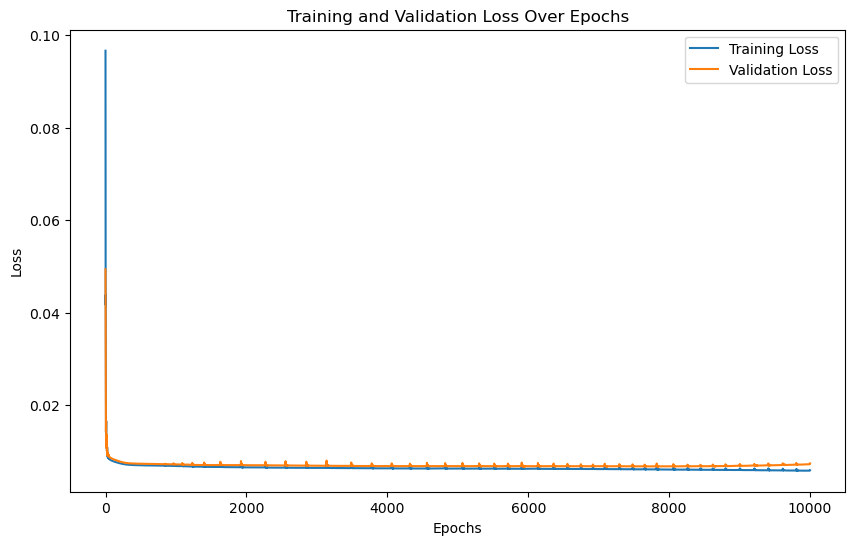

Test Loss: 0.007536998949944973


In [ ]:
epochs = 10000
train_losses = []
val_losses = []


for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    train_predictions = model(X_train_tensor)
    train_loss = model.loss_function(train_predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = model.loss_function(val_predictions, y_val_tensor)
        val_losses.append(val_loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")


# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Over Epochs")
plt.show()

model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = model.loss_function(test_predictions, y_test_tensor)
    print(f"Test Loss: {test_loss.item()}")
    
y_pred_rescaled = scaler_y.inverse_transform(test_predictions.cpu().numpy())
y_test_rescaled = scaler_y.inverse_transform(y_test_tensor.cpu().numpy())




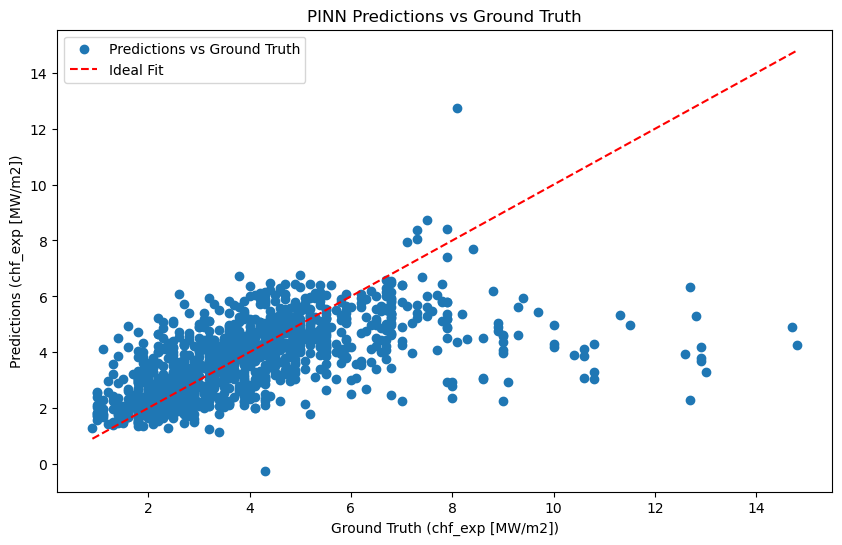

In [6]:
# Plot predictions vs ground truth
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, label="Predictions vs Ground Truth")
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], 'r--', label="Ideal Fit")
plt.xlabel("Ground Truth (chf_exp [MW/m2])")
plt.ylabel("Predictions (chf_exp [MW/m2])")
plt.legend()
plt.title("PINN Predictions vs Ground Truth")
plt.show()

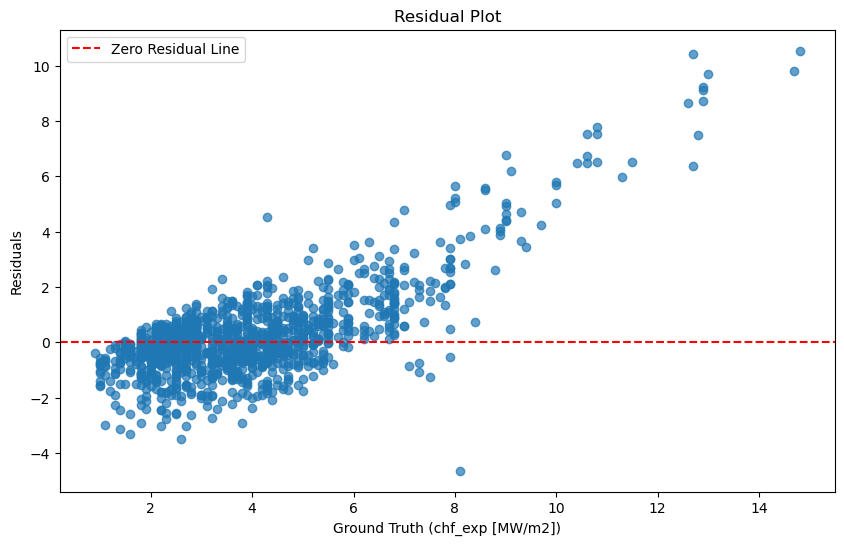

In [7]:
# Residual plot
residuals = y_test_rescaled - y_pred_rescaled
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.xlabel("Ground Truth (chf_exp [MW/m2])")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.show()


# PINN for 1D Heat Equation (Finite Difference as Ground Truth)


In [ ]:
def generate_ground_truth(q, L, n_points, T_left, T_right):
    """
    Solve d²T/dx² = q using finite difference.
    Args:
        q (float): Heat source term.
        L (float): Length of the domain.
        n_points (int): Number of grid points.
        T_left (float): Boundary condition at x = 0.
        T_right (float): Boundary condition at x = L.

    Returns:
        x (numpy array): Grid points.
        T (numpy array): Temperature at grid points.
    """
    dx = L / (n_points - 1)  # Step Size
    x = np.linspace(0, L, n_points)

    # Coefficient matrix for finite difference
    A = np.zeros((n_points, n_points))
    b = np.full(n_points, -q)  

    # Internal nodes
    for i in range(1, n_points - 1):
        A[i, i - 1] = 1 / dx**2
        A[i, i] = -2 / dx**2
        A[i, i + 1] = 1 / dx**2

    # Boundary conditions
    A[0, 0] = 1
    b[0] = T_left
    A[-1, -1] = 1
    b[-1] = T_right

    T = np.linalg.solve(A, b)
    return x, T

In [ ]:
# Parameters 
q = 1.0  # Heat source term
L = 1.0  # Length of the domain
n_points = 100  # Number of grid points
T_left = 1.0  # Temperature at x = 0
T_right = 0.0  # Temperature at x = L

x, T_exact = generate_ground_truth(q, L, n_points, T_left, T_right)
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1).requires_grad_(True)
T_tensor = torch.tensor(T_exact, dtype=torch.float32).unsqueeze(1)

In [ ]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()
    
    def forward(self, x):
        for i in range(len(self.linears) - 1):
            x = self.activation(self.linears[i](x))
        return self.linears[-1](x)

In [ ]:
layers = [1, 20, 20, 20, 20, 1]  # Input -> 4 hidden layers -> Output
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def physics_loss(model, x):
    T_pred = model(x)
    T_x = autograd.grad(T_pred, x, torch.ones_like(T_pred), create_graph=True)[0]
    T_xx = autograd.grad(T_x, x, torch.ones_like(T_x), create_graph=True)[0]
    physics_residual = T_xx + q  # d²T/dx² + q = 0
    return torch.mean(physics_residual**2)

Epoch 0, Data Loss: 0.44727, Physics Loss: 1.13406, Total Loss: 1.58133
Epoch 500, Data Loss: 0.00000, Physics Loss: 0.00017, Total Loss: 0.00017
Epoch 1000, Data Loss: 0.00000, Physics Loss: 0.00006, Total Loss: 0.00006
Epoch 1500, Data Loss: 0.00000, Physics Loss: 0.00001, Total Loss: 0.00001
Epoch 2000, Data Loss: 0.00000, Physics Loss: 0.00000, Total Loss: 0.00000
Epoch 2500, Data Loss: 0.00000, Physics Loss: 0.00000, Total Loss: 0.00000
Epoch 3000, Data Loss: 0.00000, Physics Loss: 0.00000, Total Loss: 0.00000
Epoch 3500, Data Loss: 0.00000, Physics Loss: 0.00000, Total Loss: 0.00000
Epoch 4000, Data Loss: 0.00000, Physics Loss: 0.00000, Total Loss: 0.00000
Epoch 4500, Data Loss: 0.00000, Physics Loss: 0.00000, Total Loss: 0.00000


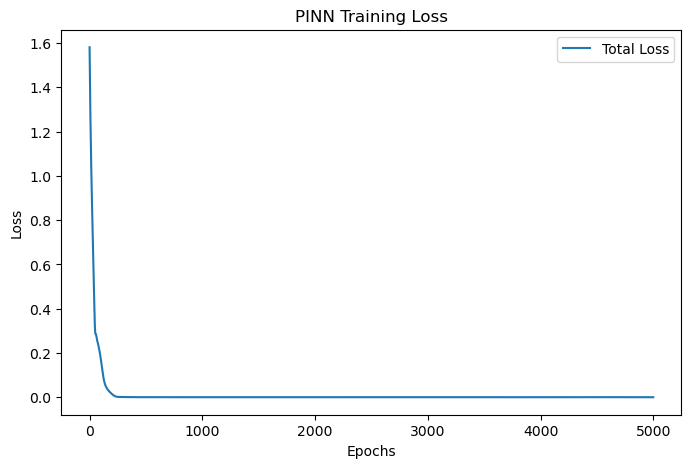

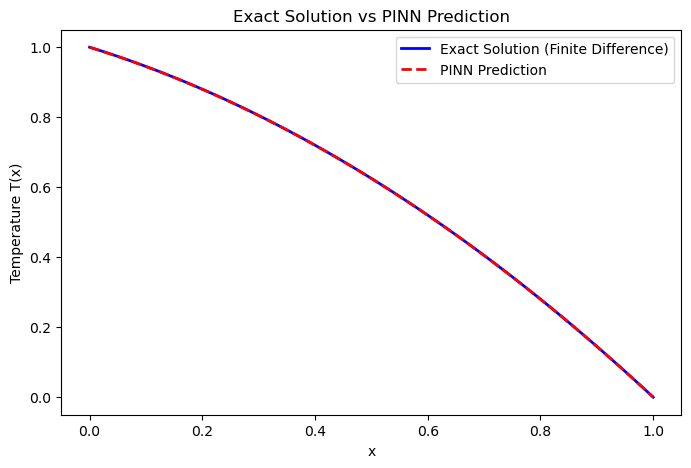

In [8]:
epochs = 5000
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    T_pred = model(x_tensor)
    data_loss = torch.mean((T_pred - T_tensor)**2)

    # Physics loss
    phys_loss = physics_loss(model, x_tensor)

    # Total loss
    total_loss = data_loss + phys_loss
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Data Loss: {data_loss.item():.5f}, Physics Loss: {phys_loss.item():.5f}, Total Loss: {total_loss.item():.5f}")

# Plot 
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("PINN Training Loss")
plt.legend()
plt.show()

# Evaluate
model.eval()
with torch.no_grad():
    x_test = np.linspace(0, L, n_points).reshape(-1, 1)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
    T_pred = model(x_test_tensor).detach().numpy()

# Plot 
plt.figure(figsize=(8, 5))
plt.plot(x, T_exact, label="Exact Solution (Finite Difference)", color="blue", linewidth=2)
plt.plot(x_test, T_pred, label="PINN Prediction", linestyle="dashed", color="red", linewidth=2)
plt.xlabel("x")
plt.ylabel("Temperature T(x)")
plt.title("Exact Solution vs PINN Prediction")
plt.legend()
plt.show()


# Heat and Moisture Transport in 2D

In [ ]:
Lx, Ly = 1.0, 1.0  # Domain size
nx, ny = 50, 50  # Number of grid points
dx, dy = Lx / (nx - 1), Ly / (ny - 1)
dt = 0.01  # Time step
nt = 200  # Number of time steps

x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Physical parameters
kappa = 0.01  # Thermal diffusivity
D = 0.01  # Moisture diffusivity
v = np.array([0.1, 0.1])  # Wind velocity (u, v)
Q_T = np.zeros((ny, nx))  # Heat source
Q_T[20:30, 20:30] = 10.0  # Localized heat source
Q_W = np.zeros((ny, nx))  # Moisture source
Q_W[10:15, 10:15] = 5.0  # Localized moisture source

In [ ]:
# Initial conditions
T = np.zeros((ny, nx))  # Initial temperature
W = np.zeros((ny, nx))  # Initial moisture

# Finite difference loop
for n in range(nt):
    # Temperature updates
    T_new = T.copy()
    T_new[1:-1, 1:-1] = (
        T[1:-1, 1:-1]
        + kappa * dt * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
            + (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )
        - dt * v[0] * (T[2:, 1:-1] - T[:-2, 1:-1]) / (2 * dx)
        - dt * v[1] * (T[1:-1, 2:] - T[1:-1, :-2]) / (2 * dy)
        + dt * Q_T[1:-1, 1:-1]
    )
    T = T_new.copy()

    # Moisture updates
    W_new = W.copy()
    W_new[1:-1, 1:-1] = (
        W[1:-1, 1:-1]
        + D * dt * (
            (W[2:, 1:-1] - 2 * W[1:-1, 1:-1] + W[:-2, 1:-1]) / dx**2
            + (W[1:-1, 2:] - 2 * W[1:-1, 1:-1] + W[1:-1, :-2]) / dy**2
        )
        - dt * v[0] * (W[2:, 1:-1] - W[:-2, 1:-1]) / (2 * dx)
        - dt * v[1] * (W[1:-1, 2:] - W[1:-1, :-2]) / (2 * dy)
        + dt * Q_W[1:-1, 1:-1]
    )
    W = W_new.copy()

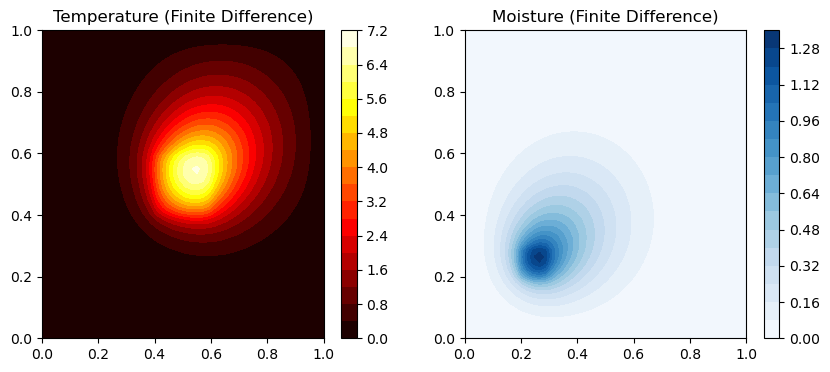

In [9]:
# Plot 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.contourf(X, Y, T, levels=20, cmap="hot")
plt.colorbar()
plt.title("Temperature (Finite Difference)")
plt.subplot(1, 2, 2)
plt.contourf(X, Y, W, levels=20, cmap="Blues")
plt.colorbar()
plt.title("Moisture (Finite Difference)")
plt.show()


In [ ]:
# Generate ground truth with finite difference
def generate_ground_truth(q_T, q_W, Lx, Ly, nx, ny, nt, T_bc, W_bc):
    """
    Generate synthetic ground truth using finite difference for heat and moisture equations.
    """
    dx = Lx / (nx - 1)
    dy = Ly / (ny - 1)
    dt = min(dx**2 / 4, dy**2 / 4)  # CFL condition for stability
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y)

    # Initialize temperature (T) and moisture (W)
    T = np.zeros((ny, nx))
    W = np.zeros((ny, nx))

    # Source terms
    Q_T = np.zeros((ny, nx))
    Q_T[20:30, 20:30] = q_T
    Q_W = np.zeros((ny, nx))
    Q_W[10:15, 10:15] = q_W

    for n in range(nt):
        T_new = T.copy()
        W_new = W.copy()

        # Update T using finite difference
        T_new[1:-1, 1:-1] = T[1:-1, 1:-1] + dt * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
            + (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
            + Q_T[1:-1, 1:-1]
        )

        # Update W using finite difference
        W_new[1:-1, 1:-1] = W[1:-1, 1:-1] + dt * (
            (W[2:, 1:-1] - 2 * W[1:-1, 1:-1] + W[:-2, 1:-1]) / dx**2
            + (W[1:-1, 2:] - 2 * W[1:-1, 1:-1] + W[1:-1, :-2]) / dy**2
            + Q_W[1:-1, 1:-1]
        )

        # Apply Dirichlet boundary conditions
        T_new[:, 0], T_new[:, -1], T_new[0, :], T_new[-1, :] = T_bc
        W_new[:, 0], W_new[:, -1], W_new[0, :], W_new[-1, :] = W_bc

        T, W = T_new, W_new

    return X, Y, T, W

In [ ]:
# Generate synthetic ground truth
Lx, Ly = 1.0, 1.0
nx, ny = 50, 50
nt = 200
q_T, q_W = 1.0, 0.5
T_bc = [1.0, 0.0, 1.0, 0.0]
W_bc = [0.5, 0.0, 0.5, 0.0]

X, Y, T, W = generate_ground_truth(q_T, q_W, Lx, Ly, nx, ny, nt, T_bc, W_bc)

x_tensor = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).requires_grad_(True)
y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1).requires_grad_(True)
T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).unsqueeze(1)
W_tensor = torch.tensor(W.flatten(), dtype=torch.float32).unsqueeze(1)


indices = np.arange(x_tensor.shape[0])
np.random.shuffle(indices)
train_split = int(0.7 * len(indices))
val_split = int(0.85 * len(indices))

train_idx = indices[:train_split]
val_idx = indices[train_split:val_split]
test_idx = indices[val_split:]

x_train, y_train = x_tensor[train_idx], y_tensor[train_idx]
T_train, W_train = T_tensor[train_idx], W_tensor[train_idx]
x_val, y_val = x_tensor[val_idx], y_tensor[val_idx]
T_val, W_val = T_tensor[val_idx], W_tensor[val_idx]
x_test, y_test = x_tensor[test_idx], y_tensor[test_idx]
T_test, W_test = T_tensor[test_idx], W_tensor[test_idx]


In [ ]:

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()

    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)
        for i in range(len(self.linears) - 1):
            xy = self.activation(self.linears[i](xy))
        return self.linears[-1](xy)


layers = [2, 50, 50, 50, 2]  # Input: (x, y) -> Outputs: (T, W)
model = PINN(layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:

def physics_loss(model, x, y):
    T_pred, W_pred = model(x, y).split(1, dim=1)

    # First derivatives
    T_x = autograd.grad(T_pred, x, torch.ones_like(T_pred), create_graph=True)[0]
    T_y = autograd.grad(T_pred, y, torch.ones_like(T_pred), create_graph=True)[0]
    W_x = autograd.grad(W_pred, x, torch.ones_like(W_pred), create_graph=True)[0]
    W_y = autograd.grad(W_pred, y, torch.ones_like(W_pred), create_graph=True)[0]

    # Second derivatives
    T_xx = autograd.grad(T_x, x, torch.ones_like(T_x), create_graph=True)[0]
    T_yy = autograd.grad(T_y, y, torch.ones_like(T_y), create_graph=True)[0]
    W_xx = autograd.grad(W_x, x, torch.ones_like(W_x), create_graph=True)[0]
    W_yy = autograd.grad(W_y, y, torch.ones_like(W_y), create_graph=True)[0]

    # Physics residuals
    T_residual = T_xx + T_yy - q_T
    W_residual = W_xx + W_yy - q_W

    return torch.mean(T_residual**2) + torch.mean(W_residual**2)

In [ ]:
train_losses = []
val_losses = []
epochs = 10000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    T_pred_train, W_pred_train = model(x_train, y_train).split(1, dim=1)
    data_loss_train = torch.mean((T_pred_train - T_train)**2) + torch.mean((W_pred_train - W_train)**2)
    
    phys_loss_train = physics_loss(model, x_train, y_train)

    total_loss_train = data_loss_train + phys_loss_train
    total_loss_train.backward(retain_graph=True)  
    optimizer.step()

    train_losses.append(total_loss_train.item())
    model.eval()
    x_val = x_val.clone().detach().requires_grad_(True)
    y_val = y_val.clone().detach().requires_grad_(True)

    with torch.no_grad():
        T_pred_val, W_pred_val = model(x_val, y_val).split(1, dim=1)
        data_loss_val = torch.mean((T_pred_val - T_val)**2) + torch.mean((W_pred_val - W_val)**2)

    phys_loss_val = physics_loss(model, x_val, y_val)
    total_loss_val = data_loss_val + phys_loss_val
    val_losses.append(total_loss_val.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Train Loss: {total_loss_train.item()}, Val Loss: {total_loss_val.item()}")

Epoch 0, Train Loss: 1.5960965156555176, Val Loss: 1.4842653274536133
Epoch 500, Train Loss: 0.038306862115859985, Val Loss: 0.035215094685554504
Epoch 1000, Train Loss: 0.03790184482932091, Val Loss: 0.03490648791193962
Epoch 1500, Train Loss: 0.036962222307920456, Val Loss: 0.03415960446000099
Epoch 2000, Train Loss: 0.03514030948281288, Val Loss: 0.03303878754377365
Epoch 2500, Train Loss: 0.033128783106803894, Val Loss: 0.0317673534154892
Epoch 3000, Train Loss: 0.03118988499045372, Val Loss: 0.03029358945786953
Epoch 3500, Train Loss: 0.029206736013293266, Val Loss: 0.029174674302339554
Epoch 4000, Train Loss: 0.028154198080301285, Val Loss: 0.0286319088190794
Epoch 4500, Train Loss: 0.027860231697559357, Val Loss: 0.02834749035537243
Epoch 5000, Train Loss: 0.027317846193909645, Val Loss: 0.028253227472305298
Epoch 5500, Train Loss: 0.030523324385285378, Val Loss: 0.03024040162563324
Epoch 6000, Train Loss: 0.026945458725094795, Val Loss: 0.02797853946685791
Epoch 6500, Train Los

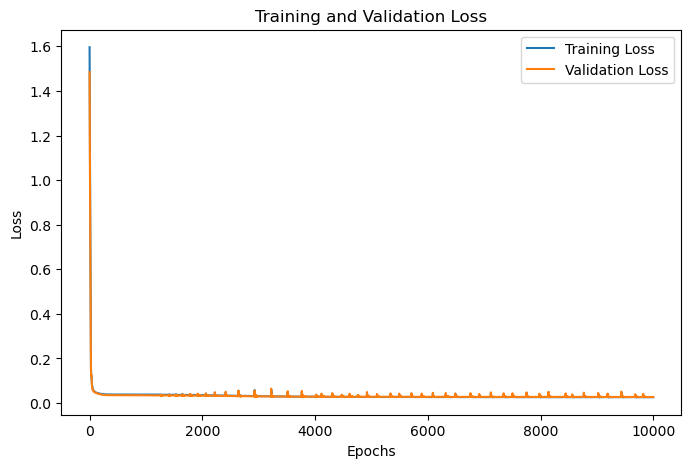

Test Data Loss: 0.026559431105852127, Test Physics Loss: 0.0001613903441466391, Test Total Loss: 0.026720821857452393


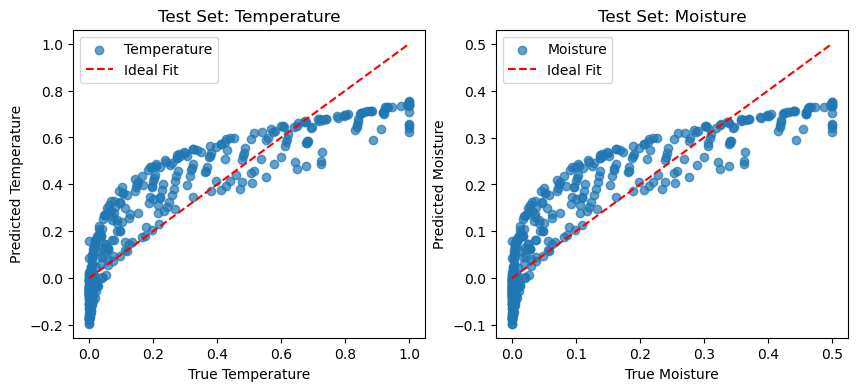

In [4]:
# Plot 
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()
x_test = x_test.clone().detach().requires_grad_(True)
y_test = y_test.clone().detach().requires_grad_(True)
x_test = x_test.clone().detach().requires_grad_(True)
y_test = y_test.clone().detach().requires_grad_(True)

model.eval()

T_pred_test, W_pred_test = model(x_test, y_test).split(1, dim=1)
test_data_loss = torch.mean((T_pred_test - T_test)**2) + torch.mean((W_pred_test - W_test)**2)
test_phys_loss = physics_loss(model, x_test, y_test)

test_total_loss = test_data_loss + test_phys_loss
print(f"Test Data Loss: {test_data_loss.item()}, Test Physics Loss: {test_phys_loss.item()}, Test Total Loss: {test_total_loss.item()}")


# Visualize 
T_pred_test = T_pred_test.detach().numpy().reshape(-1)
W_pred_test = W_pred_test.detach().numpy().reshape(-1)
T_test = T_test.detach().numpy().reshape(-1)
W_test = W_test.detach().numpy().reshape(-1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(T_test, T_pred_test, alpha=0.7, label="Temperature")
plt.plot([T_test.min(), T_test.max()], [T_test.min(), T_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("True Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Test Set: Temperature")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(W_test, W_pred_test, alpha=0.7, label="Moisture")
plt.plot([W_test.min(), W_test.max()], [W_test.min(), W_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("True Moisture")
plt.ylabel("Predicted Moisture")
plt.title("Test Set: Moisture")
plt.legend()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

nx, ny = 50, 50  
x_uniform = np.linspace(x_test.detach().numpy().min(), x_test.detach().numpy().max(), nx)
y_uniform = np.linspace(y_test.detach().numpy().min(), y_test.detach().numpy().max(), ny)
X_uniform, Y_uniform = np.meshgrid(x_uniform, y_uniform)


x_test_np = x_test.detach().numpy().flatten() if isinstance(x_test, torch.Tensor) else x_test.flatten()
y_test_np = y_test.detach().numpy().flatten() if isinstance(y_test, torch.Tensor) else y_test.flatten()
T_test_np = T_test.flatten()  
W_test_np = W_test.flatten()  
T_pred_test_np = T_pred_test.flatten()  
W_pred_test_np = W_pred_test.flatten()


In [ ]:
# Interpolate the actual and predicted values onto the uniform grid
T_actual_grid = griddata(
    points=(x_test_np, y_test_np),
    values=T_test_np,
    xi=(X_uniform, Y_uniform),
    method='cubic'
)

T_predicted_grid = griddata(
    points=(x_test_np, y_test_np),
    values=T_pred_test_np,
    xi=(X_uniform, Y_uniform),
    method='cubic'
)

W_actual_grid = griddata(
    points=(x_test_np, y_test_np),
    values=W_test_np,
    xi=(X_uniform, Y_uniform),
    method='cubic'
)

W_predicted_grid = griddata(
    points=(x_test_np, y_test_np),
    values=W_pred_test_np,
    xi=(X_uniform, Y_uniform),
    method='cubic'
)

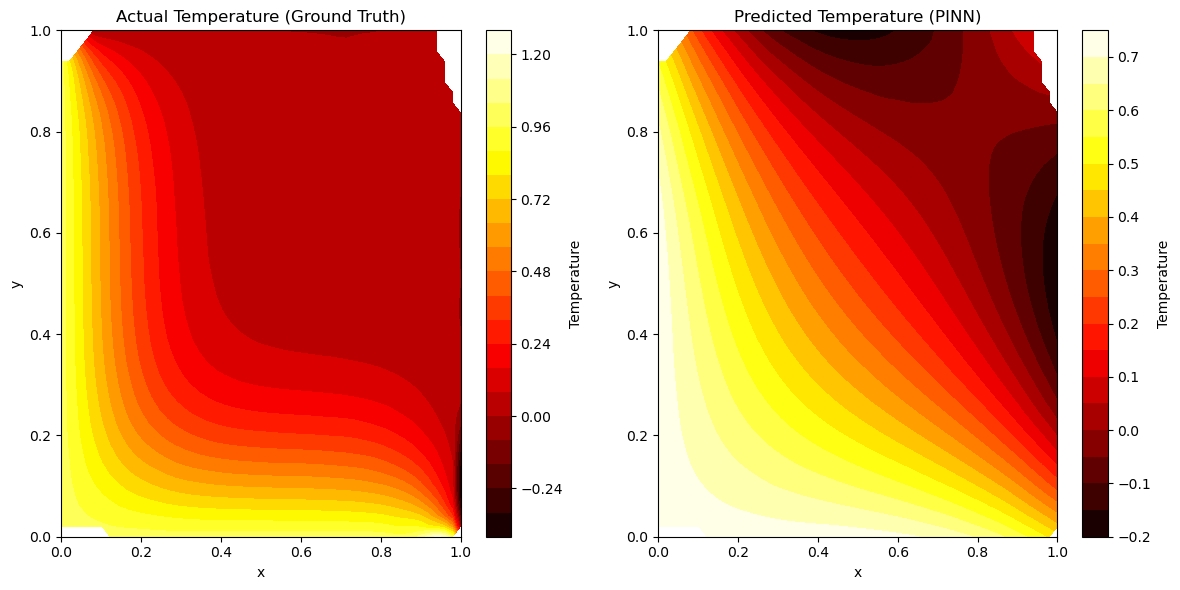

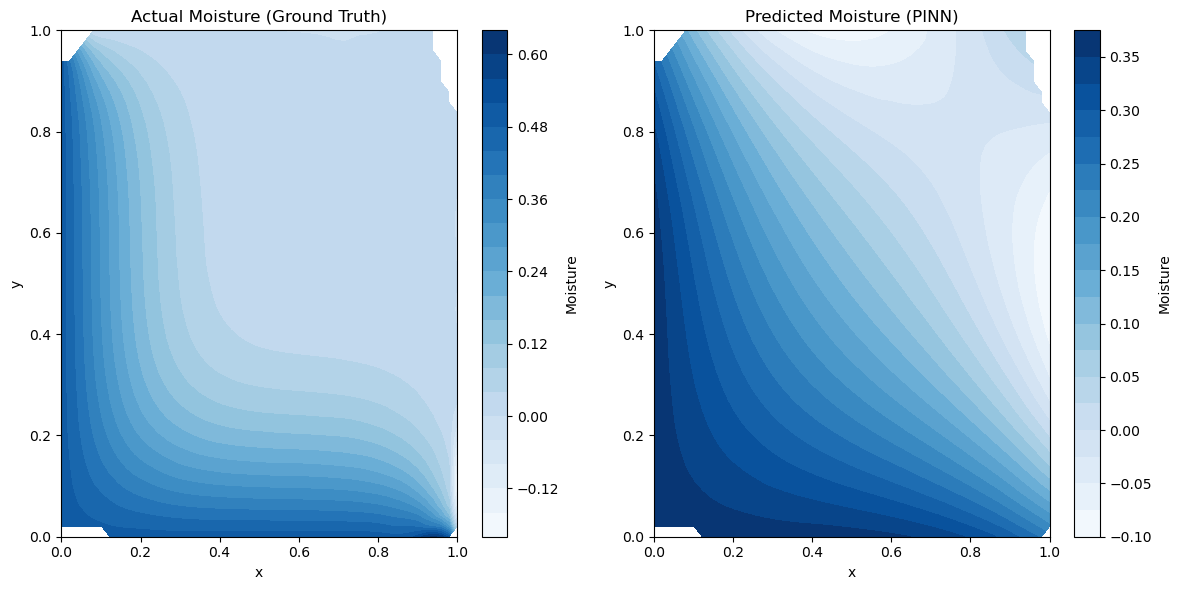

In [32]:
# Plot heatmaps for Temperature
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.contourf(X_uniform, Y_uniform, T_actual_grid, levels=20, cmap="hot")
plt.colorbar(label="Temperature")
plt.title("Actual Temperature (Ground Truth)")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1, 2, 2)
plt.contourf(X_uniform, Y_uniform, T_predicted_grid, levels=20, cmap="hot")
plt.colorbar(label="Temperature")
plt.title("Predicted Temperature (PINN)")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

# Plot heatmaps for Moisture
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.contourf(X_uniform, Y_uniform, W_actual_grid, levels=20, cmap="Blues")
plt.colorbar(label="Moisture")
plt.title("Actual Moisture (Ground Truth)")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1, 2, 2)
plt.contourf(X_uniform, Y_uniform, W_predicted_grid, levels=20, cmap="Blues")
plt.colorbar(label="Moisture")
plt.title("Predicted Moisture (PINN)")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()


In [36]:
# Calculate residuals
T_residual = T_test - T_pred_test
W_residual = W_test - W_pred_test

residual_size = T_residual.shape[0]
train_split_residual = int(0.7 * residual_size)
val_split_residual = int(0.85 * residual_size)

residual_indices = np.arange(residual_size)
np.random.shuffle(residual_indices)

train_idx_residual = residual_indices[:train_split_residual]
val_idx_residual = residual_indices[train_split_residual:val_split_residual]
test_idx_residual = residual_indices[val_split_residual:]

T_residual_train, T_residual_val, T_residual_test = (
    T_residual[train_idx_residual],
    T_residual[val_idx_residual],
    T_residual[test_idx_residual],
)

W_residual_train, W_residual_val, W_residual_test = (
    W_residual[train_idx_residual],
    W_residual[val_idx_residual],
    W_residual[test_idx_residual],
)


In [37]:
# Residual PINN
model_residual = PINN(layers)
optimizer_residual = torch.optim.Adam(model_residual.parameters(), lr=0.001)

train_residual_losses = []
val_residual_losses = []

epochs_residual = 5000
for epoch in range(epochs_residual):
    model_residual.train()
    optimizer_residual.zero_grad()
    T_residual_pred_train, W_residual_pred_train = model_residual(x_test[train_idx_residual], y_test[train_idx_residual]).split(1, dim=1)
    loss_train_residual = (
        torch.mean((T_residual_pred_train - torch.tensor(T_residual_train).unsqueeze(1)) ** 2)
        + torch.mean((W_residual_pred_train - torch.tensor(W_residual_train).unsqueeze(1)) ** 2)
    )

    loss_train_residual.backward()
    optimizer_residual.step()
    train_residual_losses.append(loss_train_residual.item())
    model_residual.eval()
    with torch.no_grad():
        T_residual_pred_val, W_residual_pred_val = model_residual(
            x_test[val_idx_residual], y_test[val_idx_residual]
        ).split(1, dim=1)
        loss_val_residual = (
            torch.mean((T_residual_pred_val - torch.tensor(T_residual_val).unsqueeze(1)) ** 2)
            + torch.mean((W_residual_pred_val - torch.tensor(W_residual_val).unsqueeze(1)) ** 2)
        )
        val_residual_losses.append(loss_val_residual.item())

    if epoch % 500 == 0:
        print(f"Residual PINN Epoch {epoch}, Train Loss: {loss_train_residual.item()}, Val Loss: {loss_val_residual.item()}")


Residual PINN Epoch 0, Train Loss: 0.10951117426156998, Val Loss: 0.05188728868961334
Residual PINN Epoch 500, Train Loss: 0.004290103446692228, Val Loss: 0.001661408576183021
Residual PINN Epoch 1000, Train Loss: 0.003446037182584405, Val Loss: 0.001502172090113163
Residual PINN Epoch 1500, Train Loss: 0.003075909335166216, Val Loss: 0.0011467300355434418
Residual PINN Epoch 2000, Train Loss: 0.0028840063605457544, Val Loss: 0.0010666376911103725
Residual PINN Epoch 2500, Train Loss: 0.00269150547683239, Val Loss: 0.0006934135453775525
Residual PINN Epoch 3000, Train Loss: 0.0024594159331172705, Val Loss: 0.0005041555850766599
Residual PINN Epoch 3500, Train Loss: 0.002141627250239253, Val Loss: 0.00047453606384806335
Residual PINN Epoch 4000, Train Loss: 0.0018181093037128448, Val Loss: 0.0005224226042628288
Residual PINN Epoch 4500, Train Loss: 0.0016059308545663953, Val Loss: 0.0004957442870363593


In [38]:
model_residual.eval()
with torch.no_grad():
    T_residual_pred_test, W_residual_pred_test = model_residual(
        x_test[test_idx_residual], y_test[test_idx_residual]
    ).split(1, dim=1)

# Combine original predictions with residual predictions
T_combined = T_pred_test[test_idx_residual] + T_residual_pred_test.numpy().reshape(-1)
W_combined = W_pred_test[test_idx_residual] + W_residual_pred_test.numpy().reshape(-1)

T_combined_error = np.mean((T_combined - T_test[test_idx_residual]) ** 2)
W_combined_error = np.mean((W_combined - W_test[test_idx_residual]) ** 2)

print(f"Combined Temperature Error: {T_combined_error}")
print(f"Combined Moisture Error: {W_combined_error}")


Combined Temperature Error: 0.0003511472314130515
Combined Moisture Error: 9.771791519597173e-05


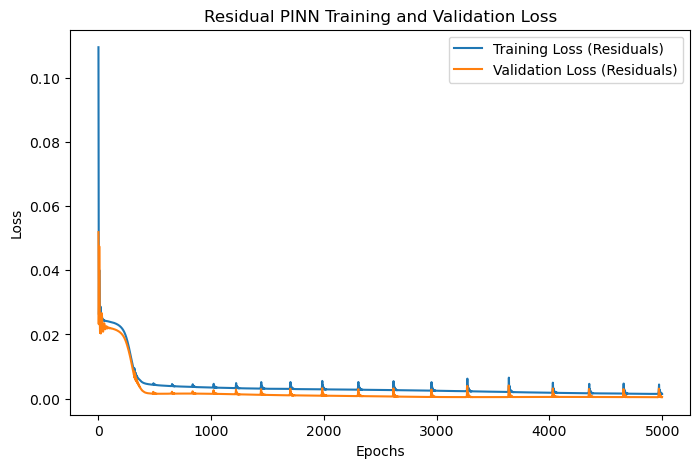

In [39]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_residual_losses, label="Training Loss (Residuals)")
plt.plot(val_residual_losses, label="Validation Loss (Residuals)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Residual PINN Training and Validation Loss")
plt.show()


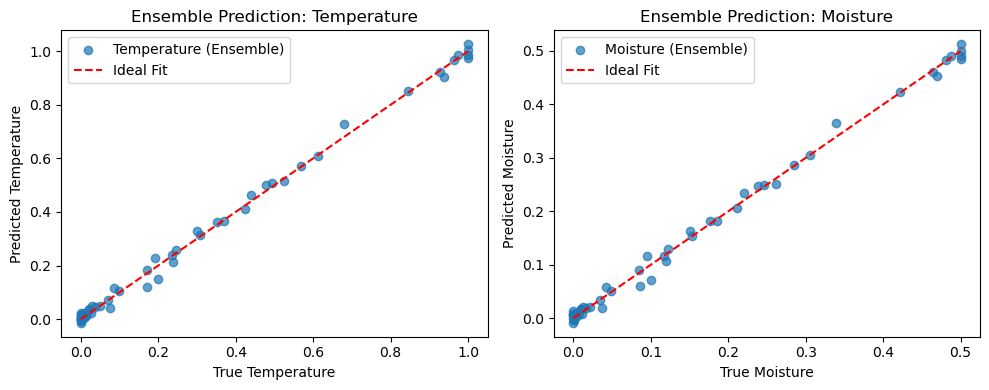

In [40]:
# Scatter plots for the ensemble predictions
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(T_test[test_idx_residual], T_combined, alpha=0.7, label="Temperature (Ensemble)")
plt.plot(
    [T_test[test_idx_residual].min(), T_test[test_idx_residual].max()],
    [T_test[test_idx_residual].min(), T_test[test_idx_residual].max()],
    'r--',
    label="Ideal Fit",
)
plt.xlabel("True Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Ensemble Prediction: Temperature")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(W_test[test_idx_residual], W_combined, alpha=0.7, label="Moisture (Ensemble)")
plt.plot(
    [W_test[test_idx_residual].min(), W_test[test_idx_residual].max()],
    [W_test[test_idx_residual].min(), W_test[test_idx_residual].max()],
    'r--',
    label="Ideal Fit",
)
plt.xlabel("True Moisture")
plt.ylabel("Predicted Moisture")
plt.title("Ensemble Prediction: Moisture")
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
T_residual_train = T_train - T_pred_train.reshape(-1)
W_residual_train = W_train - W_pred_train.reshape(-1)

T_residual_val = T_val - T_pred_val.reshape(-1)
W_residual_val = W_val - W_pred_val.reshape(-1)

T_residual_test = T_test - T_pred_test.reshape(-1)
W_residual_test = W_test - W_pred_test.reshape(-1)


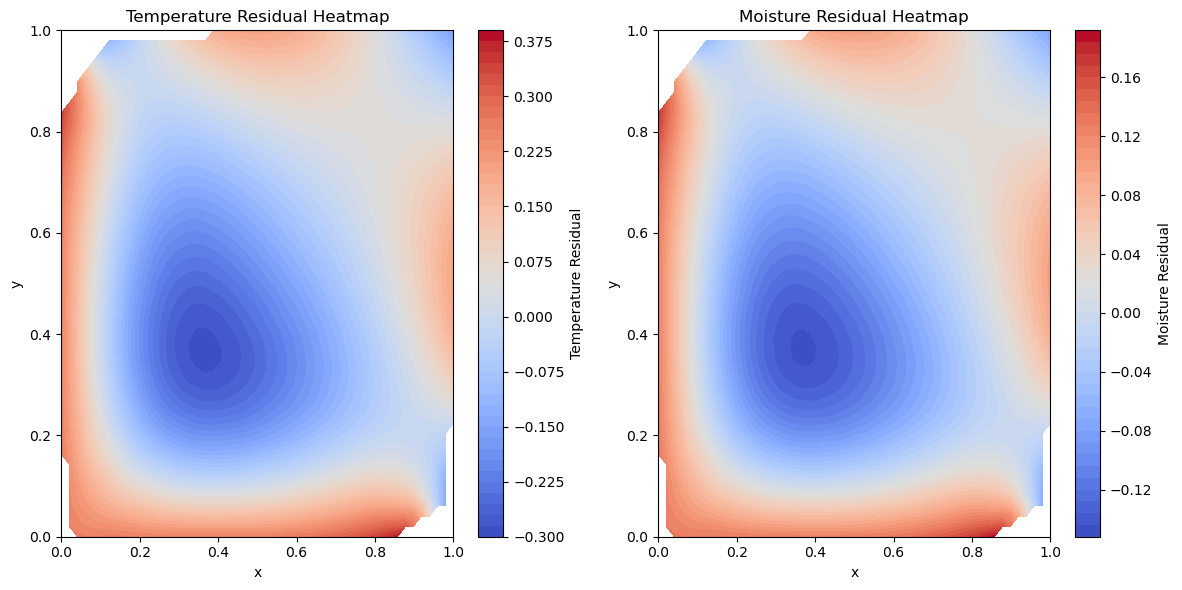

In [ ]:
x_test_np = x_test.detach().numpy().flatten()
y_test_np = y_test.detach().numpy().flatten()
T_residual_np = T_residual_test.flatten()  
W_residual_np = W_residual_test.flatten()  

nx, ny = 50, 50 
grid_x = np.linspace(x_test_np.min(), x_test_np.max(), nx)
grid_y = np.linspace(y_test_np.min(), y_test_np.max(), ny)
X_grid, Y_grid = np.meshgrid(grid_x, grid_y)

T_residual_grid = griddata(
    (x_test_np, y_test_np), T_residual_np, (X_grid, Y_grid), method="cubic"
)
W_residual_grid = griddata(
    (x_test_np, y_test_np), W_residual_np, (X_grid, Y_grid), method="cubic"
)

# Plot heatmaps of residuals
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.contourf(X_grid, Y_grid, T_residual_grid, levels=50, cmap="coolwarm")
plt.colorbar(label="Temperature Residual")
plt.title("Temperature Residual Heatmap")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1, 2, 2)
plt.contourf(X_grid, Y_grid, W_residual_grid, levels=50, cmap="coolwarm")
plt.colorbar(label="Moisture Residual")
plt.title("Moisture Residual Heatmap")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()


# 2D Transient Heat Equation

In [ ]:
# Generate ground truth using finite difference
def generate_ground_truth(Lx, Ly, nx, ny, nt, alpha, T_init, T_bc):
   dx = Lx / (nx - 1)
   dy = Ly / (ny - 1)
   dt = min(dx**2, dy**2) / (4 * alpha)  # CFL condition

   x = np.linspace(0, Lx, nx)
   y = np.linspace(0, Ly, ny)
   t = np.linspace(0, dt * nt, nt)
   X, Y = np.meshgrid(x, y)

   T = np.zeros((nt, ny, nx))
   T[0, :, :] = T_init(X, Y)

   for n in range(0, nt - 1):
       T[n + 1, 1:-1, 1:-1] = T[n, 1:-1, 1:-1] + alpha * dt * (
           (T[n, 2:, 1:-1] - 2 * T[n, 1:-1, 1:-1] + T[n, :-2, 1:-1]) / dx**2
           + (T[n, 1:-1, 2:] - 2 * T[n, 1:-1, 1:-1] + T[n, 1:-1, :-2]) / dy**2
       )

       # Apply boundary conditions
       T[n + 1, :, 0] = T_bc(X[:, 0], Y[:, 0])
       T[n + 1, :, -1] = T_bc(X[:, -1], Y[:, -1])
       T[n + 1, 0, :] = T_bc(X[0, :], Y[0, :])
       T[n + 1, -1, :] = T_bc(X[-1, :], Y[-1, :])

   return X, Y, t, T

def T_init(X, Y):
   return np.sin(np.pi * X) * np.sin(np.pi * Y)

def T_bc(X, Y):
   return 0


# Generate ground truth data
Lx, Ly = 1.0, 1.0
nx, ny, nt = 50, 50, 100
alpha = 0.01
X, Y, t, T_true = generate_ground_truth(Lx, Ly, nx, ny, nt, alpha, T_init, T_bc)

x_grid = X.flatten()[:, None]
y_grid = Y.flatten()[:, None]

t_grid = np.zeros((nx*ny*nt, 1))
x_repeated = np.zeros((nx*ny*nt, 1))
y_repeated = np.zeros((nx*ny*nt, 1))
T_flat = np.zeros((nx*ny*nt, 1))

for i in range(nt):
   t_grid[i*(nx*ny):(i+1)*(nx*ny), 0] = t[i]
   x_repeated[i*(nx*ny):(i+1)*(nx*ny), 0] = x_grid[:, 0]
   y_repeated[i*(nx*ny):(i+1)*(nx*ny), 0] = y_grid[:, 0]
   T_flat[i*(nx*ny):(i+1)*(nx*ny), 0] = T_true[i].flatten()

In [ ]:
x_tensor = torch.tensor(x_repeated, dtype=torch.float32, requires_grad=True)
y_tensor = torch.tensor(y_repeated, dtype=torch.float32, requires_grad=True)
t_tensor = torch.tensor(t_grid, dtype=torch.float32, requires_grad=True)
T_tensor = torch.tensor(T_flat, dtype=torch.float32)

# Split data
n_samples = len(x_tensor)
train_idx = int(0.7 * n_samples)
val_idx = int(0.85 * n_samples)

x_train = x_tensor[:train_idx]
y_train = y_tensor[:train_idx]
t_train = t_tensor[:train_idx]
x_val = x_tensor[train_idx:val_idx]
y_val = y_tensor[train_idx:val_idx]
t_val = t_tensor[train_idx:val_idx]
x_test = x_tensor[val_idx:]
y_test = y_tensor[val_idx:]
t_test = t_tensor[val_idx:]

T_train = T_tensor[:train_idx]
T_val = T_tensor[train_idx:val_idx]
T_test = T_tensor[val_idx:]

In [ ]:
class PINN(nn.Module):
   def __init__(self, layers):
       super(PINN, self).__init__()
       self.linears = nn.ModuleList()
       for i in range(len(layers) - 1):
           self.linears.append(nn.Linear(layers[i], layers[i + 1]))
       self.activation = nn.Tanh()

   def forward(self, x, y, t):
       inputs = torch.cat([x, y, t], dim=1)
       for i in range(len(self.linears) - 1):
           inputs = self.activation(self.linears[i](inputs))
       return self.linears[-1](inputs)

def physics_loss(model, x, y, t, alpha):
   u_pred = model(x, y, t)
   
   u_t = autograd.grad(u_pred, t, torch.ones_like(u_pred), create_graph=True)[0]
   u_x = autograd.grad(u_pred, x, torch.ones_like(u_pred), create_graph=True)[0]
   u_y = autograd.grad(u_pred, y, torch.ones_like(u_pred), create_graph=True)[0]
   u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
   u_yy = autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]

   residual = u_t - alpha * (u_xx + u_yy)
   return torch.mean(residual**2)

layers = [3, 50, 50, 50, 1]
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 0, Train Loss: 0.264484, Val Loss: 0.155503
Epoch 100, Train Loss: 0.075245, Val Loss: 0.063462
Epoch 200, Train Loss: 0.069651, Val Loss: 0.058140
Epoch 300, Train Loss: 0.016147, Val Loss: 0.011355
Epoch 400, Train Loss: 0.001198, Val Loss: 0.000761
Epoch 500, Train Loss: 0.000665, Val Loss: 0.000453
Epoch 600, Train Loss: 0.000458, Val Loss: 0.000329
Epoch 700, Train Loss: 0.000350, Val Loss: 0.000260
Epoch 800, Train Loss: 0.000279, Val Loss: 0.000211
Epoch 900, Train Loss: 0.000243, Val Loss: 0.000180
Test Loss: 0.000198


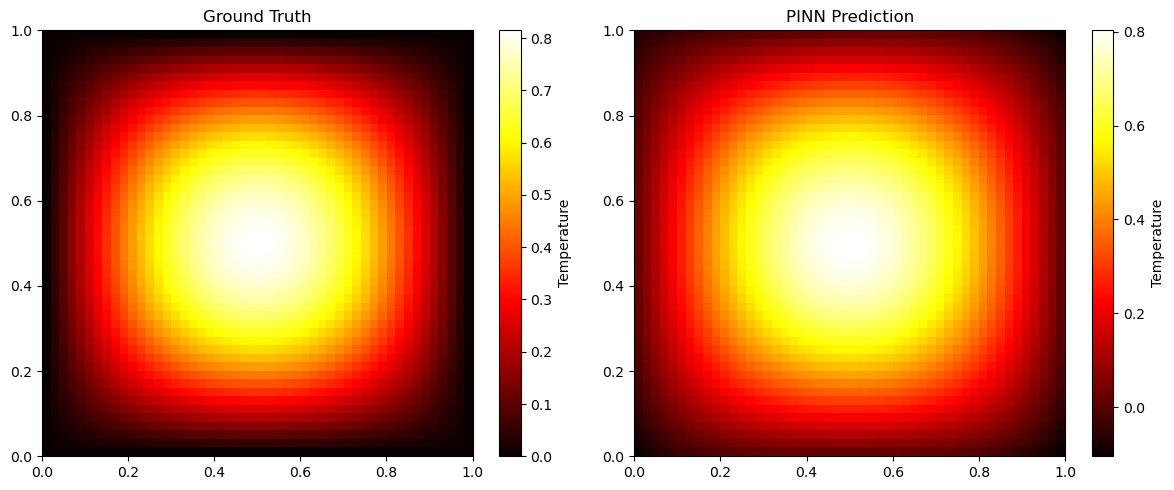

In [ ]:
train_losses = []
val_losses = []
epochs = 1000

for epoch in range(epochs):
   model.train()
   optimizer.zero_grad()

   u_pred_train = model(x_train, y_train, t_train)
   data_loss = torch.mean((u_pred_train - T_train)**2)
   phys_loss = physics_loss(model, x_train, y_train, t_train, alpha)
   total_loss = data_loss + phys_loss

   total_loss.backward()
   optimizer.step()

   train_losses.append(total_loss.item())

   model.eval()
   with torch.no_grad():
       u_pred_val = model(x_val, y_val, t_val)
       val_loss = torch.mean((u_pred_val - T_val)**2)
       val_losses.append(val_loss.item())

   if epoch % 100 == 0:
       print(f"Epoch {epoch}, Train Loss: {total_loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

model.eval()
with torch.no_grad():
   u_pred_test = model(x_test, y_test, t_test)
   test_loss = torch.mean((u_pred_test - T_test)**2)
   print(f"Test Loss: {test_loss.item():.6f}")

# Plot 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.imshow(T_true[-1], extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="hot")
plt.colorbar(label="Temperature")

plt.subplot(1, 2, 2)
plt.title("PINN Prediction")
T_pred_final = u_pred_test[-nx*ny:].reshape(ny, nx).detach().numpy()
plt.imshow(T_pred_final, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="hot")
plt.colorbar(label="Temperature")

plt.tight_layout()
plt.show()

# 1D Seismic Wave Equation

In [ ]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        for i in range(len(self.linears) - 1):
            inputs = self.activation(self.linears[i](inputs))
        return self.linears[-1](inputs)


In [ ]:
def seismic_wave_loss(model, x, t, c):
    u_pred = model(x, t)
    u_t = autograd.grad(u_pred, t, torch.ones_like(u_pred), create_graph=True)[0]
    u_tt = autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]

    u_x = autograd.grad(u_pred, x, torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    residual = u_tt - c**2 * u_xx
    return torch.mean(residual**2)


In [ ]:
def boundary_initial_conditions_loss(model, x, t, c):
    # Initial condition: u(x, 0) = sin(pi * x), du/dt(x, 0) = 0
    t0 = torch.zeros_like(x, requires_grad=True)
    u0_pred = model(x, t0)
    u0_true = torch.sin(np.pi * x)
    u_t0_pred = autograd.grad(u0_pred, t0, torch.ones_like(u0_pred), create_graph=True, allow_unused=True)[0]

    initial_loss = torch.mean((u0_pred - u0_true)**2) + torch.mean(u_t0_pred**2)

    # Boundary conditions: u(0, t) = u(1, t) = 0
    x_boundary = torch.tensor([[0.0], [1.0]], dtype=torch.float32, requires_grad=True).repeat(t.shape[0], 1)
    t_boundary = t.repeat(2, 1).T.reshape(-1, 1) 
    u_boundary_pred = model(x_boundary, t_boundary)
    boundary_loss = torch.mean(u_boundary_pred**2)

    return initial_loss + boundary_loss

In [ ]:
# Finite Difference Method (FDM) for ground truth
def finite_difference_wave(nx, nt, L, T, c):
    dx = L / (nx - 1)
    dt = T / (nt - 1)

    # CFL condition
    CFL = c * dt / dx
    if CFL > 1:
        raise ValueError("CFL condition not satisfied. Reduce dt or increase dx.")
    u = np.zeros((nt, nx))

    # Initial conditions
    x = np.linspace(0, L, nx)
    u[0, :] = np.sin(np.pi * x)  # u(x, 0) = sin(pi * x)
    u[1, :] = u[0, :]  # du/dt(x, 0) = 0
    
    for n in range(1, nt - 1):
        for i in range(1, nx - 1):
            u[n + 1, i] = (
                2 * u[n, i] - u[n - 1, i]
                + CFL**2 * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1])
            )

    return u

In [ ]:
L = 1.0  # Domain length
T = 1.0  # Total time
nx, nt = 100, 100
x = np.linspace(0, L, nx)
t = np.linspace(0, T, nt)
X, T_grid = np.meshgrid(x, t)

x_tensor = torch.tensor(X.flatten(), dtype=torch.float32, requires_grad=True).unsqueeze(1)
t_tensor = torch.tensor(T_grid.flatten(), dtype=torch.float32, requires_grad=True).unsqueeze(1)



In [ ]:
c = 1.0  # Wave speed for seismic equation
layers = [2, 50, 50, 50, 1]  # 2 inputs: x, t -> Output: u(x, t)
model = PINN(layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5000
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    physics_loss = seismic_wave_loss(model, x_tensor, t_tensor, c)
    boundary_loss = boundary_initial_conditions_loss(model, x_tensor, t_tensor, c)
    total_loss = physics_loss + boundary_loss
    total_loss.backward()
    optimizer.step()
    train_losses.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item()}")
model.eval()
with torch.no_grad():
    u_pred_test = model(x_tensor, t_tensor).detach().numpy()

u_pred_test_grid = u_pred_test.reshape(nt, nx)
u_fdm = finite_difference_wave(nx, nt, L, T, c)

Epoch 0, Total Loss: 0.3740641176700592
Epoch 500, Total Loss: 0.0025015375576913357
Epoch 1000, Total Loss: 0.00036866439040750265
Epoch 1500, Total Loss: 0.0005770662683062255
Epoch 2000, Total Loss: 0.0022623289842158556
Epoch 2500, Total Loss: 0.0003864990721922368
Epoch 3000, Total Loss: 0.0028693003114312887
Epoch 3500, Total Loss: 0.00011311219714116305
Epoch 4000, Total Loss: 0.00010475273302290589
Epoch 4500, Total Loss: 9.716548083815724e-05


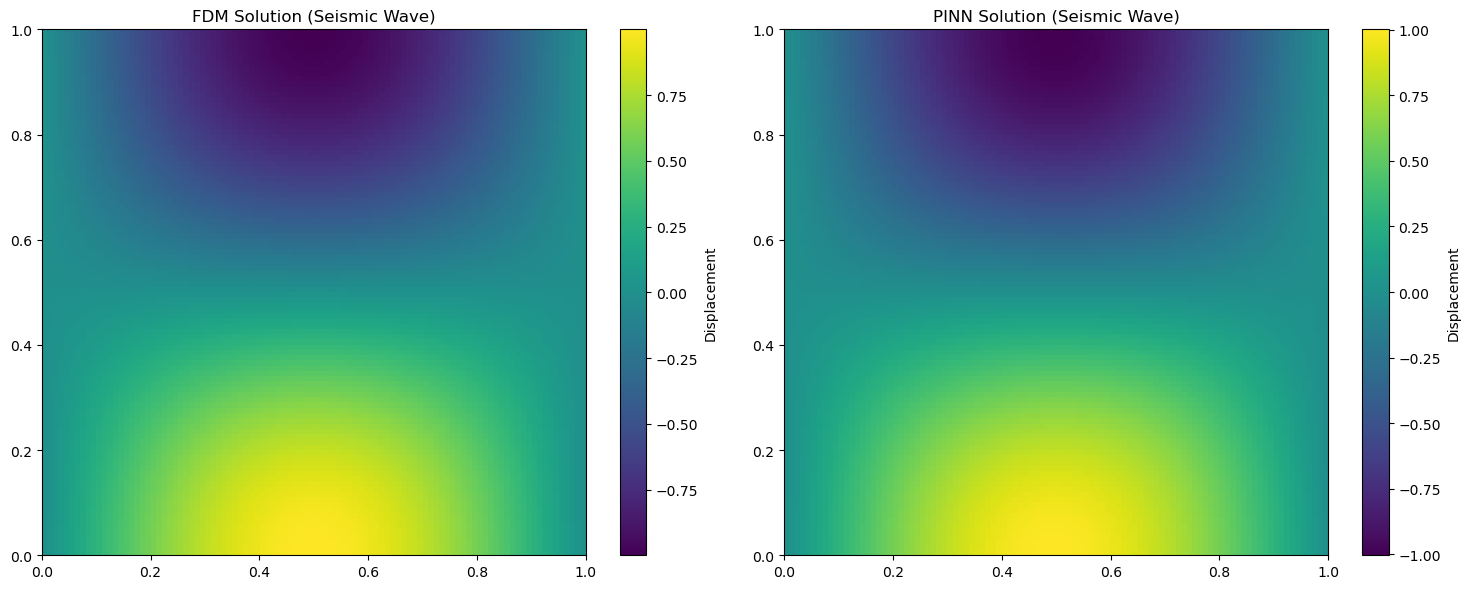

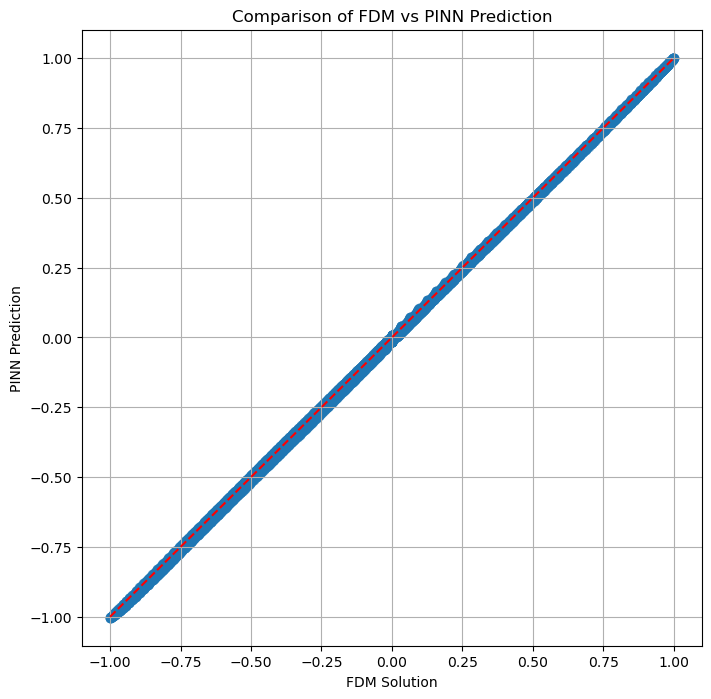

In [97]:

plt.figure(figsize=(15, 6))

# FDM Solution
plt.subplot(1, 2, 1)
plt.imshow(
    u_fdm,
    extent=[0, L, 0, T],
    origin="lower",
    aspect="auto",
    cmap="viridis",
)
plt.colorbar(label="Displacement")
plt.title("FDM Solution (Seismic Wave)")

# PINN solution plot
plt.subplot(1, 2, 2)
plt.imshow(
    u_pred_test_grid,
    extent=[0, L, 0, T],
    origin="lower",
    aspect="auto",
    cmap="viridis",
)
plt.colorbar(label="Displacement")
plt.title("PINN Solution (Seismic Wave)")

plt.tight_layout()
plt.show()

# Scatter Plot: FDM vs PINN
plt.figure(figsize=(8, 8))
plt.scatter(u_fdm.flatten(), u_pred_test.flatten(), alpha=0.5)
plt.xlabel("FDM Solution")
plt.ylabel("PINN Prediction")
plt.title("Comparison of FDM vs PINN Prediction")
plt.plot([u_fdm.min(), u_fdm.max()], [u_fdm.min(), u_fdm.max()], 'r--')  # y=x line
plt.grid()
plt.show()
